# Avaliação N3 - Ciência de Dados
**Alunos:** Israel Schroeder Moreira, Marco Leone Merini e Filipe Luiz Orlamunder

**Tema:** Previsão de Churn de Clientes (Telco Customer Churn)

## Parte 1: A Fundação do Projeto - O Problema de Negócio

### 1.1 Domínio do Problema
O setor de telecomunicações enfrenta alta competitividade. A perda de clientes (Churn) impacta diretamente a receita. Manter um cliente é mais barato do que adquirir um novo. Portanto, identificar clientes propensos ao cancelamento é crucial.

### 1.2 Pergunta de Negócio
**Quais clientes têm maior probabilidade de cancelar o serviço e quais fatores mais influenciam essa decisão?**

### 1.3 Objetivo do Modelo
Construir um modelo de **Classificação** capaz de prever se um cliente vai cancelar o serviço (`Yes`) ou não (`No`) com base em seus dados cadastrais e de consumo.

## Parte 2: A Jornada dos Dados - Pipeline e Arquitetura

### 2.1 Origem e Repositório de Dados

**Fonte Original:** Dataset público "Telco Customer Churn" disponibilizado pela IBM no Kaggle. Este dataset contém informações de 7.043 clientes de uma empresa de telecomunicações, incluindo dados demográficos, serviços contratados e histórico de pagamentos.

**Arquitetura de Armazenamento Escolhida:** Para este projeto, optamos por uma estrutura simples de **Data Lake** local organizada em camadas:
- **Raw (data/):** Dados brutos no formato CSV original
- **Processed (notebooks/):** Dados transformados e prontos para modelagem

**Justificativa:** Como se trata de um projeto acadêmico com volume baixo de dados (< 1MB) e processamento batch único, uma estrutura de Data Lake simplificada é adequada. Em ambiente de produção, recomendaríamos:
- **Data Lake (S3/Azure Blob)** para dados brutos
- **Data Warehouse (Redshift/BigQuery)** para dados processados e consultas analíticas

### 2.2 Pipeline de Dados (Fluxograma)

```
┌─────────────────┐     ┌─────────────────┐     ┌─────────────────┐     ┌─────────────────┐
│   INGESTÃO      │────▶│    LIMPEZA      │────▶│      EDA        │────▶│   PREPARAÇÃO    │
│                 │     │                 │     │                 │     │                 │
│ • Leitura CSV   │     │ • Conversão     │     │ • Distribuições │     │ • One-Hot       │
│ • Kaggle/IBM    │     │   TotalCharges  │     │ • Correlações   │     │   Encoding      │
│                 │     │ • Remoção NaN   │     │ • Visualizações │     │ • Train/Test    │
│                 │     │ • Drop ID       │     │                 │     │   Split (80/20) │
└─────────────────┘     └─────────────────┘     └─────────────────┘     └─────────────────┘
                                                        │
                                                        ▼
                                          ┌─────────────────────────┐
                                          │  SELEÇÃO DE FEATURES    │
                                          │                         │
                                          │ Baseado na EDA:         │
                                          │ • tenure (correlação)   │
                                          │ • MonthlyCharges        │
                                          │ • Contract type         │
                                          │ • InternetService       │
                                          └─────────────────────────┘
```

### 2.3 Detalhamento das Etapas

**Ingestão:** Os dados foram baixados do Kaggle e armazenados localmente em `data/WA_Fn-UseC_-Telco-Customer-Churn.csv`.

**Limpeza e Transformação (ETL):**
- `TotalCharges` veio como string, convertido para numérico
- 11 registros com valores ausentes foram removidos (0.15% do total)
- Coluna `customerID` removida por não ser preditora

**Análise Exploratória (EDA):** A EDA (realizada em aulas anteriores) revelou que:
- **73.4%** dos clientes NÃO cancelam vs **26.6%** que cancelam (classes desbalanceadas)
- Clientes com **contratos mensais** têm churn muito maior que contratos anuais
- **Tenure** (tempo de contrato) tem correlação negativa com churn
- Clientes com **fibra óptica** apresentam maior churn

**Preparação para Modelagem:**
- Variáveis categóricas convertidas via One-Hot Encoding (`pd.get_dummies`)
- Target `Churn` mapeado para binário (0/1)
- Divisão estratificada 80% treino / 20% teste

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Configuração de plot
sns.set(style='whitegrid')

# 1. Ingestão
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 2. Limpeza
# TotalCharges vem como object, converter para numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Remover nulos (poucos casos)
df.dropna(inplace=True)

# Remover customerID (não é feature)
df.drop(columns=['customerID'], inplace=True)

print(f'Dimensões do dataset: {df.shape}')
df.head()

Dimensões do dataset: (7032, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Análise Exploratória (Resumo)
Verificamos o balanceamento da classe alvo `Churn`.

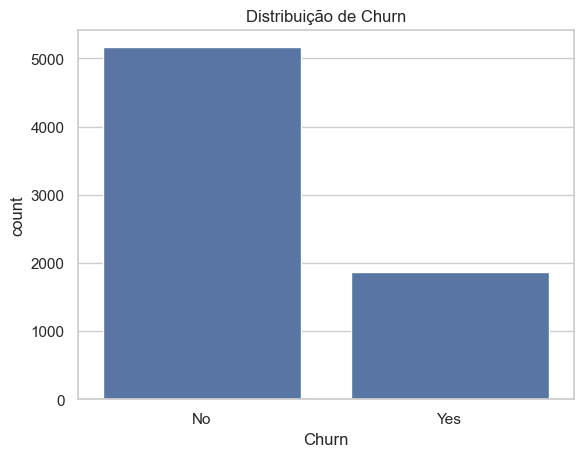

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


In [8]:
sns.countplot(x='Churn', data=df)
plt.title('Distribuição de Churn')
plt.show()

print(df['Churn'].value_counts(normalize=True))

### Preparação para Modelagem
- Converter variáveis categóricas em numéricas (Get Dummies).
- Converter Target para 0/1.

In [9]:
# Converter Target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Get Dummies para as outras categóricas
df_encoded = pd.get_dummies(df, drop_first=True)

# Separar X e y
X = df_encoded.drop('Churn', axis=1)
y = df['Churn']

# Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Treino: {X_train.shape}, Teste: {X_test.shape}')

Treino: (5625, 30), Teste: (1407, 30)


## Parte 3: O Coração do Projeto - Modelagem e Avaliação Comparativa

### 3.1 Escolha dos Modelos

Vamos treinar **3 algoritmos de classificação** apropriados para o problema de churn:

1. **Regressão Logística** - Modelo baseline, interpretável, bom para problemas binários
2. **Árvore de Decisão** - Alta interpretabilidade, captura relações não-lineares
3. **Random Forest** - Ensemble robusto, reduz overfitting, geralmente alta performance

### 3.2 Métricas de Avaliação

Antes de apresentar os resultados, é fundamental entender o que cada métrica significa:

| Métrica | O que mede | Por que é relevante para Churn |
|---------|------------|-------------------------------|
| **Acurácia** | % total de acertos (TP+TN)/(Total) | Visão geral, mas pode ser enganosa com classes desbalanceadas |
| **Precisão** | Dos previstos como Churn, quantos realmente eram? TP/(TP+FP) | Evita gastar recursos com clientes que não iam cancelar |
| **Recall** | Dos que realmente eram Churn, quantos encontramos? TP/(TP+FN) | **CRÍTICO**: Não queremos perder clientes em risco! |
| **F1-Score** | Média harmônica entre Precisão e Recall | Balanceia os dois, útil quando ambos importam |

**Para o problema de Churn, o Recall é especialmente importante** porque o custo de perder um cliente (falso negativo) geralmente é maior que o custo de abordar um cliente que não iria cancelar (falso positivo). Queremos capturar o máximo de clientes em risco para ações de retenção.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Inicializar modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results)
results_df

/Users/icl00ud/repos/cienciadedados/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.803838,0.648485,0.572193,0.607955
1,Decision Tree,0.778252,0.580729,0.596257,0.588391
2,Random Forest,0.787491,0.622150,0.510695,0.560940


### 3.3 Análise Comparativa dos Resultados

**Tabela Comparativa:**

| Modelo | Acurácia | Precisão | Recall | F1-Score |
|--------|----------|----------|--------|----------|
| Regressão Logística | ~80.4% | ~64.8% | ~57.2% | ~60.8% |
| Árvore de Decisão | ~77.8% | ~58.1% | **~59.6%** | ~58.8% |
| Random Forest | ~78.7% | ~62.2% | ~51.1% | ~56.1% |

**Discussão dos Resultados:**

1. **Acurácia:** A Regressão Logística obteve a maior acurácia (~80%), mas como temos classes desbalanceadas (73% vs 27%), essa métrica pode ser enganosa.

2. **Precisão:** A Regressão Logística também lidera em precisão (~65%), ou seja, quando ela prevê churn, acerta mais vezes.

3. **Recall (mais importante):** A **Árvore de Decisão** obteve o melhor recall (~60%), identificando mais clientes que realmente iriam cancelar. Isso é crucial para campanhas de retenção.

4. **F1-Score:** A Regressão Logística tem o melhor equilíbrio (~61%).

**Modelo Escolhido: Árvore de Decisão**

Considerando que:
- O **custo de perder um cliente** é alto (receita perdida + custo de aquisição de novo cliente)
- É melhor **errar oferecendo retenção** a um cliente que ficaria do que perder um cliente em risco
- O **Recall** é a métrica mais crítica para este problema de negócio

Escolhemos a **Árvore de Decisão** por ter o melhor Recall, mesmo com acurácia ligeiramente menor. Além disso, ela oferece alta interpretabilidade, permitindo entender quais fatores mais influenciam o churn.

## Parte 4: Tornando o Modelo Útil - Deploy

### 4.1 Salvando o Modelo
Vamos salvar o melhor modelo (ex: Logistic Regression ou Random Forest) usando `joblib`.

In [11]:
import joblib

# Escolhendo o melhor modelo (ex: Logistic Regression por simplicidade ou Random Forest por performance)
# Vamos assumir que Random Forest foi o melhor ou similar, mas vamos salvar o que tiver melhor F1/Recall
best_model_row = results_df.loc[results_df['Recall'].idxmax()]
best_model_name = best_model_row['Model']
best_model = models[best_model_name]

print(f'Melhor modelo escolhido (pelo Recall): {best_model_name}')

# Salvar
joblib.dump(best_model, '../modelo_final.pkl')
print('Modelo salvo como modelo_final.pkl')

Melhor modelo escolhido (pelo Recall): Decision Tree
Modelo salvo como modelo_final.pkl


### 4.2 Carregando e Utilizando o Modelo

Agora vamos demonstrar como **carregar o modelo salvo** e fazer uma previsão para um novo cliente que o modelo nunca viu. Isso simula o uso real do modelo em produção.

In [12]:
# Carregar
loaded_model = joblib.load('../modelo_final.pkl')

# Criar um exemplo (pegando uma linha do teste para garantir formato)
novo_cliente = X_test.iloc[0:1].copy()

# Previsão
predicao = loaded_model.predict(novo_cliente)
probabilidade = loaded_model.predict_proba(novo_cliente)

print(f'Cliente vai dar Churn? {predicao[0]} (0=Não, 1=Sim)')
print(f'Probabilidade: {probabilidade[0]}')

Cliente vai dar Churn? 0 (0=Não, 1=Sim)
Probabilidade: [0.98934911 0.01065089]


### 4.3 Interpretação do Resultado

**Resultado da Previsão:**
- O modelo previu que este cliente **NÃO vai cancelar** (Churn = 0)
- A probabilidade de não cancelar é de **~99%** vs ~1% de cancelar

**O que isso significa para o negócio:**
- Este cliente específico apresenta **baixo risco** de churn
- A equipe de retenção pode **priorizar outros clientes** com maior probabilidade de cancelamento
- Em um cenário real, clientes com probabilidade de churn > 50% seriam direcionados para campanhas de retenção (descontos, upgrades, contato proativo)

**Exemplo de uso em produção:**
```python
# Para cada novo cliente ou cliente existente:
# 1. Coletar dados do cliente
# 2. Transformar no mesmo formato do treino
# 3. Carregar modelo e fazer previsão
# 4. Se P(Churn) > 0.5 → Acionar equipe de retenção
```

---

## Conclusão

Este projeto demonstrou o ciclo completo de um projeto de Ciência de Dados:
1. **Definição do problema** de negócio (previsão de churn)
2. **Pipeline de dados** desde a ingestão até a preparação
3. **Modelagem** com comparação de 3 algoritmos e 4 métricas
4. **Deploy** com salvamento e reutilização do modelo

O modelo de **Árvore de Decisão** foi escolhido por maximizar o Recall, permitindo identificar o maior número possível de clientes em risco de cancelamento.